DataLab document:  
[dldb1]file:///net/dl1/data/USB/demo_finding_dwarfs.ipynb  
2016/06/10 Ken Mighell  
***

# Finding the Eridanus II Dwarf Galaxy in a Photometric Catalog based on Archival DECam Observations

Kenneth Mighell

In this IPython notebook, the reader will learn how to find a nearby dwarf galaxy in a photometric catalog served by the NOAO Data Lab.


***

# Getting Started

Assuming that you have called this notebook, demo_finding_dwarfs.ipynb, start it in the normal way by typing  

**jupyter notebook demo_finding_dwarfs.ipynb**  

from a terminal window.

If nothing happens or you get an error...  
get your local computer guru to show you how to use IPython notebooks on the machine you are using.


**NOTE:** This IPython notebook was written using **Python2.7**.   *If you are using Python3.X*, this notebook will **break**.

First, we load some custom Python code in order to improve the readability of this notebook:

In [1]:
# IPython notebook

%reset -f
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from astropy.io import fits
from astropy.table import Table
from astropy import convolution
import IPython.display as dsp
from IPython.display import Image, display
import os
import os.path
import sys
import urllib

from dl import auth
from dl import queryMgr
from IPython.display import Image, display
from cStringIO import StringIO

# Get the security token for the dtat labe demo user
token = auth.login('dldemo', 'dldemo')

base_url = 'http://dldemo.sdm.noao.edu/aas228/' 

code_filename = 'dlkm_aas228_code.py'
code_url = base_url+code_filename
if not os.path.isfile(code_filename):
    print 'Retrieve', code_url, '...'
    code_file = urllib.URLopener()
    code_file.retrieve( code_url, code_filename)
    print '... done'
else:
    print 'File already exists:', code_filename
pass
# IPython magic:
%run $code_filename
print code_url, ' --> ',code_filename

# To inpect the custom Python code, 
# uncomment and run the following IPython magic command:
#%load $code_filename

mydb = [        
    {'title':'None', 'stub':'None', 'pos':'None', 'fig':'0'},     # dummy slot to match DB table
    {'title':'Reticulum II dwarf', 'stub':'ret2', 'pos':'(53.9256,-54.0492)', 'fig':'4'},
    {'title':'Eridanus II dwarf', 'stub':'eri2', 'pos':'(56.0878,-43.5332)', 'fig':'5'},
    {'title':'Horologium I dwarf', 'stub':'hor1', 'pos':'(43.8820,-54.1188)', 'fig':'6'},
    {'title':'Pictoris I dwarf', 'stub':'pic1', 'pos':'(70.9475,-50.2830)', 'fig':'7'}
]

print '\n:-)'

File already exists: dlkm_aas228_code.py
http://dldemo.sdm.noao.edu/aas228/dlkm_aas228_code.py  -->  dlkm_aas228_code.py

:-)


Get a table with astrometry data over the Internet:

In [2]:
# Select a dwarf galaxy from mydb
dwarf=2 # <== USER SELECTION (choose 1, 2, 3, or 4)

# Choose whether to use local FITS files or remote query Data Lab
use_local_files = True

assert (dwarf>0) & (dwarf<mydb.__len__()), 'bad value for dwarf'  # Check if dwarf is OK
title = mydb[dwarf]['title']
print '\nGet data for the %s galaxy...' % (title)

if use_local_files:
    data_filename = mydb[dwarf]['stub']+'_photavg.fits'
    if not os.path.isfile(data_filename):
        data = fits.getdata(base_url+data_filename,1)
    else:
        print 'File already exists:', data_filename
        data = fits.getdata(data_filename,1)
    pass
    t = Table(data)
else:
    query = 'select ra_j2000,dec_j2000,gmag,rmag from dwarfs.photavg where field = ' + str(dwarf)
    data = queryMgr.query( token, adql = query, fmt = 'csv')
    t = Table.read(StringIO(data), format='csv')
pass

print '... done!'
print '\n:-)'


Get data for the Eridanus II dwarf galaxy...
File already exists: eri2_photavg.fits
... done!

:-)


Extract the data for right ascension [degrees (time)] and declination [degrees] :

In [3]:
ra0 = t['ra_j2000'] # degrees 
dec0 = t['dec_j2000'] # degrees
g0 = t['gmag'] # mag
r0 = t['rmag'] # mag
gmr0 = g0 - r0 # mag
print ra0.size, 'objects'
print '\n:-)'

201020 objects

:-)


Show the all objects in a sky plot using a scatter plot:

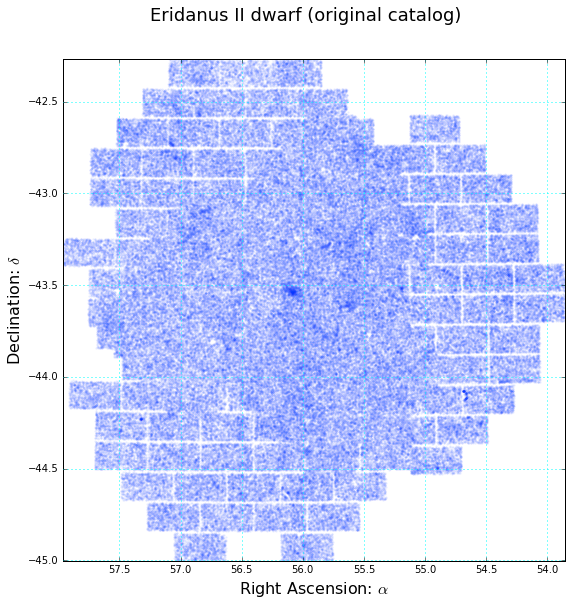


:-)


In [4]:
skyplot_scatter( ra0, dec0, title=title+' (original catalog)', size=2 )
print '\n:-)'

In [5]:
print '\nThe discovery paper of Koposov, Belokurov, Torrealba, & Evans (2015, ApJ, 805, 130)'
print 'gives the position of the', mydb[dwarf]['title'], 'galaxy as', mydb[dwarf]['pos'], '.'
print '\nDo you see the dwarf galaxy?'


The discovery paper of Koposov, Belokurov, Torrealba, & Evans (2015, ApJ, 805, 130)
gives the position of the Eridanus II dwarf galaxy as (56.0878,-43.5332) .

Do you see the dwarf galaxy?


Now plot the color-magnitude diagram (CMD) of this field:

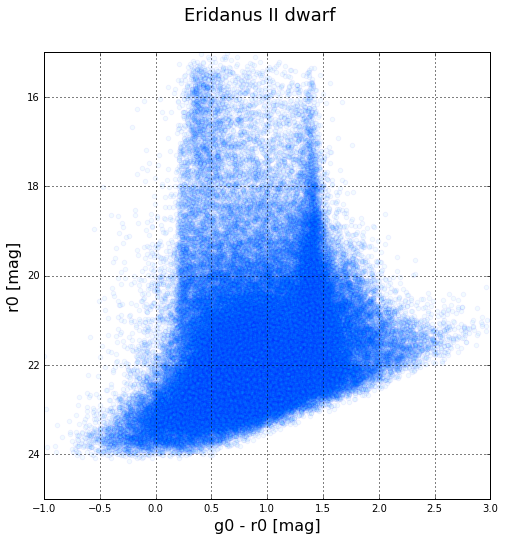

In [6]:
plot_cmd( g0-r0, r0, xlim=(-1,3), ylim=(15,25), xtitle='g0 - r0 [mag]', ytitle='r0 [mag]' ,
         title=title, size=20)

How many objects are in this color-magnitude diagram?

In [7]:
idx = (gmr0 > -1) & (gmr0 < 3) & (r0 > 15) & (r0 < 25)
print np.sum(idx), 'objects'

95498 objects


Most of the objects in the color-magnitude diagram are either 
1. stars in the Milky Way, or 
2. external galaxies.

Most of the bright objects redder than (g-r)=1.0 mag are field dwarf stars.

Let us now improve the contrast of the skyplot by making color and magnitude cuts   
to select for stars in a nearby dwarf that would be near the main sequence turnoff,  
on the subgiant branch or at the base of the red giant branch.

In [8]:
index = (gmr0 > 0) & (gmr0 < 0.6) & (r0 > 19) & (r0 < 23.5)
g1 = g0[index]
r1 = r0[index]
ra1 = ra0[index]
dec1 = dec0[index]
print '\n:-)'


:-)


In [9]:
print '\nThis selection of color and magnitude gives us a smaller catalog of %6d objects' % (r1.size)
print '--- which is a reduction in size of %6.2f percent.' % ((1-(r1.size/float(r0.size)))*100)


This selection of color and magnitude gives us a smaller catalog of  21341 objects
--- which is a reduction in size of  89.38 percent.


Let us call this smaller subset of the original catalog the "dwarf catalog."

Show the sky plot of the dwarf catalog:

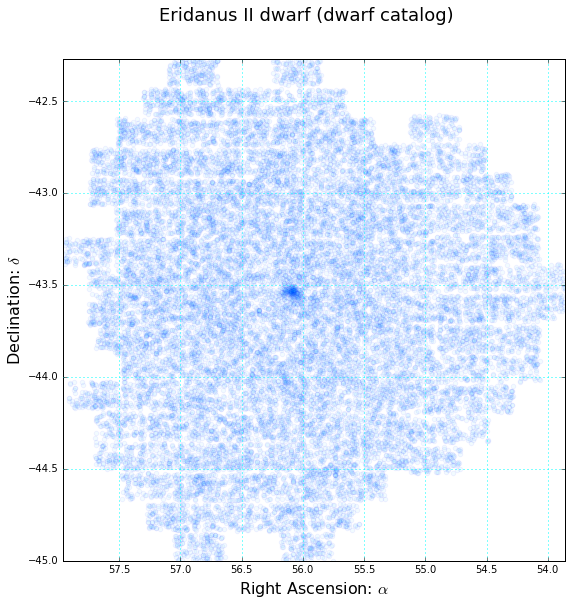


:-)


In [10]:
skyplot_scatter( ra1, dec1, title=title+' (dwarf catalog)', size=20 )
print '\n:-)'

In [11]:
print '\nNow do you see the dwarf galaxy at %s ?' % (mydb[dwarf]['pos'])



Now do you see the dwarf galaxy at (56.0878,-43.5332) ?


Congratulations! You have found a nearby Local Group dwarf galaxy in photometry catalog based on DECam observations in the NOAO Science Archive.

Note how the visual contrast between the stars in the and the background stellar field has improved compared to the previous sky plot.

Now we use some custom Python code (which was loaded in the first cell of this notebook)
to show a sky plot based on a two-dimensional (2-d) histogram of the object counts binned into 
one-arcmin by one-arcmin bins.

Let us now show the 2-d histogram of the original catalog:

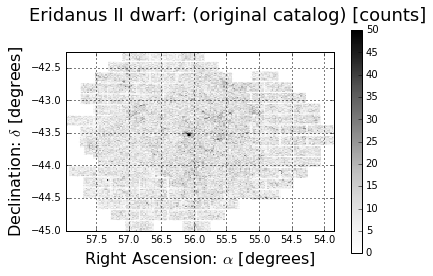

In [12]:
hist2d_countsOC, extentOC, hist2d_filterOC, hist2d_clippedOC = dlkm_aas228_dwarf_filter( 
    ra0, dec0, return_results=True, fwhm_small_arcmin=3, fwhm_big_arcmin=30)
plot_hist2d(hist2d_countsOC, extent=extentOC, title=title+': (original catalog) [counts]' )

In [13]:
print '\nDo you see the dwarf galaxy at %s ?' % (mydb[dwarf]['pos'])


Do you see the dwarf galaxy at (56.0878,-43.5332) ?


The field in the 2-d histogram appears to be a bit noisey.  

We show below that the 2-d histogram of the dwarf catalog has a much cleaner field background:

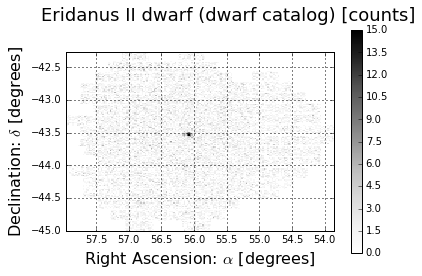

In [14]:
hist2d_countsDC, extentDC, hist2d_filterDC, hist2d_clippedDC = dlkm_aas228_dwarf_filter( 
    ra1, dec1, return_results=True, fwhm_small_arcmin=3, fwhm_big_arcmin=30)
plot_hist2d(hist2d_countsDC, extent=extentDC, title=title+' (dwarf catalog) [counts]' )


In [15]:
print '\nNow do you see the dwarf galaxy at %s ?\n' % (mydb[dwarf]['pos'])


Now do you see the dwarf galaxy at (56.0878,-43.5332) ?



Koposov, Belokurov, Evans, et al. (2008, Astrophysical Journal, 686, 279)
described how a **differential convolution kernel** can be applied to a stellar catalog
to identify overdensities of a particular scale.

The Python function **dlkm_aas228_dwarf_filter** function (used above) also generated a *filtered* version of a raw-counts 2-d histogram which is the *difference* of two-dimensional Gaussian convolution kernels with a Full-Width-at-Half-Maximum (FWHM) of 3 arcminutes and 30 arcminutes.  The small 2-d Gaussian convolution kernel with a FWHM=3 arcmin is a low-pass filter which is useful for finding objects with an approximate size of 3 arcmin.  The big 2-d Gaussian convolution kernel with a FWHM=30 arcmin is a low-pass filter which is useful for finding very big objects like the background sky.  The difference 2-d histogram is called the "dwarf filter".


This is the dwarf filter 2-d histogram of the original catalog:

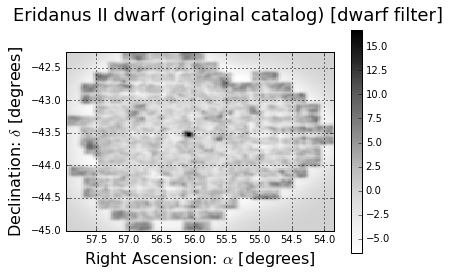

In [16]:
plot_hist2d(hist2d_filterOC, extent=extentOC, title=title+' (original catalog) [dwarf filter]' )

We see a clear enhancement at the position of the dwarf galaxy.
But we also see some "edge effects" where the dwarf filter has created enhancements
near edges of the field. A more sophisticated dwarf filter could probably be designed to minimize
such edge effects.

This is the dwarf filter 2-d histogram of the dwarf catalog:

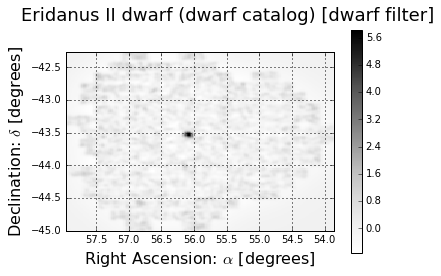

In [17]:
plot_hist2d(hist2d_filterDC, extent=extentDC, title=title+' (dwarf catalog) [dwarf filter]' )

Note the cleaner result.  

In [18]:
if dwarf == 3: # PicI
    print '\nThe %s galaxy is hard to see in the above 2d-histogram.\n' % (title)
    print 'Below is the same 2-d histogram but now we show only data between 2 and 7 standard deviations above the mean:'
    plot_hist2d(hist2d_clippedDC, extent=extentDC, title=title+' (dwarf catalog) [clipped dwarf filter]' )
    print '\nYou can now barely see the dwarf galaxy at %s .' % (mydb[dwarf]['pos'])
    print '\nUnfortunately... there is also a lot of background clutter.'
pass

In [19]:
num = mydb[dwarf]['fig']
print '\nCompare this figure with upper-left part of Figure %s of the discovery paper '\
    '(Koposov et al. 2015):' % (num)
display(Image(url=base_url+'Fig'+num+'ul_Koposov+2015.png'))


Compare this figure with upper-left part of Figure 5 of the discovery paper (Koposov et al. 2015):


In [20]:
print '\n:-)'


:-)


***

# Appendix: Using Kernel Density Estimation

If you wish to see a demonstration of the use of Kernel Density Estimation to find the  
Eridanus II dwarf galaxay in the original catalog, please **uncomment the second line in**  
**the following cell** and rerun the entire notebook by using the **"Run All"** option of the  
"Cell" menu).  

As there are many objects in the original catalog, the KDE computation **will take some time!**

In [21]:
kde_demo=False
#kde_demo=True  # <== Uncomment if you wish to see the use of Kernel Density Estimation, and then rerun with "Run All"

In [22]:
assert kde_demo, "kde_demo=False  <== USER REQUEST: the remainder of this notebook will not be executed!"

AssertionError: kde_demo=False  <== USER REQUEST: the remainder of this notebook will not be executed!

In [ ]:
assert dwarf == 2, 'Sorry! This appendix was designed for use with the Eridanus II dwarf (dwarf=0) catalog.'

In [ ]:
def do_kde( ra, dec): # Kernel Density Estimation
    from sklearn.neighbors.kde import KernelDensity
    assert (ra.size == dec.size), 'ra & dec must have the same size'
    print '*** WARNING *** This may take some time...'
    sys.stdout.flush()  
    radec = np.column_stack((ra,dec))
    # Calculate the KDE for right ascension and declination:
    kde = KernelDensity( 
    algorithm = 'ball_tree', 
    kernel = 'gaussian', 
    bandwidth = 0.05, 
    rtol = 1.e-8
    ).fit(radec)  # Knut used data[0:2].T instead of radec
    colors = kde.score_samples(radec) # This gives log results  
    idx = colors.argsort()
    kde_colors = colors
    kde_idx = idx
    return kde_colors, kde_idx
pass

def show_plots( ra, dec, g, r, gr, kde_colors, kde_idx, s = None, cmap='jet', title='' ):
    assert (ra.size == dec.size), 'ra & dec must have the same size'
    assert (g.size == gr.size), 'g & gr must have the same size'
    assert (kde_colors.size == kde_idx.size), 'kde_colors & kde_idx must have the same size'
    assert (ra.size == kde_idx.size), 'ra & kde_idx must have the same size'
    colors = kde_colors
    idx = kde_idx
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (11.0, 4.0))
    if s is None:
        cmin = np.min(colors)
        cmax = np.max(colors)
        s_ = ((colors[idx] - cmin)/(cmax - cmin))*200
    else:
        s_ = s
    sc = ax1.scatter(gr[idx], r[idx], marker = '.', c = colors[idx], 
                     s = s_, alpha = 0.5, edgecolor = '', cmap=cmap)
    ax1.set_xlim(-0.5, 2)
    ax1.set_ylim(14., 24.,)
    ax1.set_ylim(ax1.get_ylim()[::-1])
    ax1.set_xlabel("g - r [mag]", fontsize=16)
    ax1.set_ylabel("r [mag]", fontsize=16)
    ax2.scatter(ra[idx], dec[idx], marker = '.', c = colors[idx],
                s = 10, alpha = 0.5, edgecolor = '', cmap=cmap)
    #ax2.set_ylim([-45,-42.3]) # Eridanus II
    #ax2.set_xlim([53.9,58])   # Eridanus II
    ax2.set_xlim(ax2.get_xlim()[::-1]) # invert x axis
    ax2.set_xlabel(r'Right Ascension: $\alpha$', fontsize=16)
    ax2.set_ylabel(r'Declination: $\delta$', fontsize=16)
    if len(title) != 0:
        plt.suptitle(title, fontsize=18)
    plt.colorbar(sc)
    plt.show()
    return fig, ax1, ax2
pass

print '\n:-)'

Let us take an entirely different approach and use Kernel Density Estimation with the original catalog.  

We will not use any color or magnitude cuts but *will use spatial density information* in order to find    
candidate members of the Eridanus II dwarf galaxy. 

**NOTE:** The following command will take some time to compute...

In [ ]:
colors, idx = do_kde( ra0, dec0 )
print '\n:-)'

In [ ]:
show_plots( ra0, dec0, g0, r0, g0-r0, colors, idx, 
           title=title+' (original catalog)')  # color version
show_plots( ra0, dec0, g0, r0, g0-r0, colors, idx, 
           title=title+' (original catalog)', cmap='Greys' )  # grayscale version

The dark red (black) stars in the color (grayscale) version of the color-magnitude 
are candidate members of the Eridanus II dwarf galaxy. 

In its current form, these figures are hard to interpret.

We can enhance the contrast by simply not plotting any object with a KDE score below
two standard devations above the mean.

In [ ]:
colors2 = colors.copy()
mean = np.mean(colors2)
sigma = np.std(colors2)
floor_sigma = 2.0 # change to alter contrast
floor = mean + (floor_sigma*sigma)
colors2[ colors2 < floor ] = floor
show_plots( ra0, dec0, g0, r0, g0-r0, colors2, idx, 
           title=title+' (original catalog)')  # color version
show_plots( ra0, dec0, g0, r0, g0-r0, colors2, idx, 
           title=title+' (original catalog)', cmap='Greys' )  # grayscale version

The big reddish (blackish) symbols are candidate members of the Eridanus II dwarf galaxy.

Compare this figure with Figure 5 of the 
discovery paper of the Eridanus II dwarf galaxy (lower-left graph of Figure 5 of Koposov et al 2015):

In [ ]:
dsp.Image(url=base_url+'fig5cmd_Koposov+2015.png')

***



In [ ]:
print '\n:-)'